<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
%pip install ydata-profiling ipywidgets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pickle

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?

Для того, чтобы все результаты были воспроизводимы, а еще, чтобы не делали сид гиперпараметром в домашках по RecSys (ну и по другим).

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [4]:
df = pd.concat([df_train, df_test])

In [5]:
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

Колонки с пропущенными значениями: mileage, engine, max_power, torque, seats 

In [6]:
df.duplicated().sum()

1170

Да, дубликаты есть.

In [7]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")
profile

/Users/22028091/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* Очень несбалансированные типы: seller_type, fuel и transmission  
* Есть пара признаков у которых есть объекты-выбросы: например km_driven, year (1983) или seats (14). (Не факт, что их стоит убирать, но в датасете они выделяются.) А еще selling_type в 1e7.
* С max_power, engine и torque явно нужно поработать. Из графиков слов можно найти единицы измерения которые нужно убрать.

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [8]:
df_train.describe()

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [9]:
df_test.describe()

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [10]:
df_train.describe(include=[object])

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [11]:
df_test.describe(include=[object])

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

In [12]:
compare_data = {}
compare_data['train_mean'] = df_train.mean(numeric_only=True)
compare_data['train_median'] = df_train.median(numeric_only=True)
compare_data['test_mean'] = df_test.mean(numeric_only=True)
compare_data['test_median'] = df_test.median(numeric_only=True)

compare_df = pd.DataFrame(data=compare_data)
compare_df

train_mean  train_median      test_mean  test_median
year             2013.818403        2015.0    2013.681000       2014.0
selling_price  639515.197171      450000.0  617901.042000     434999.0
km_driven       69584.615517       60000.0   71393.341000      61500.0
seats               5.419008           5.0       5.410805          5.0

По данным можно увидеть, что средние и медианы на трейне и тесте не сильно отличаются и предположить, что распределения на трейне и тесте примерно идентичны и следовательно, деление было хорошим. Но сравнивать лучше конечно распределения целиком.

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [13]:
y_train = df_train['selling_price']
X_train = df_train.drop(columns=['selling_price'])

X_train.duplicated().sum()

1159

In [14]:
X_train[X_train.duplicated()].sort_values(by='name')

name  year  km_driven    fuel  \
6307  Audi Q3 2.0 TDI Quattro Premium Plus  2017      22000  Diesel   
6704               Audi Q5 3.0 TDI Quattro  2014      76131  Diesel   
6640            Audi Q5 35TDI Premium Plus  2018      31800  Diesel   
1595            Audi Q5 35TDI Premium Plus  2018      31800  Diesel   
2787            Audi Q5 35TDI Premium Plus  2018      31800  Diesel   
...                                    ...   ...        ...     ...   
6778        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
3623        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
2293        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
5652        Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   
947         Volvo XC40 D4 Inscription BSIV  2019      20000  Diesel   

     seller_type transmission        owner     mileage   engine   max_power  \
6307      Dealer    Automatic  First Owner  15.73 kmpl  1968 CC  174.33 bhp   
6704  Individual    Automatic  First Owner  13.22 kmpl  2967 CC   241.4 bhp   
6640      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC     188 bhp   
1595      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC     188 bhp   
2787      Dealer    Automatic  First Owner  17.01 kmpl  1968 CC     188 bhp   
...          ...          ...          ...         ...      ...         ...   
6778  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
3623  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
2293  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
5652  Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   
947   Individual    Automatic  First Owner   18.0 kmpl  1969 CC     190 bhp   

                   torque  seats  
6307  380Nm@ 1750-2500rpm    5.0  
6704  580Nm@ 1400-3250rpm    5.0  
6640  400nm@ 1750-3000rpm    5.0  
1595  400nm@ 1750-3000rpm    5.0  
2787  400nm@ 1750-3000rpm    5.0  
...                   ...    ...  
6778                400Nm    5.0  
3623                400Nm    5.0  
2293                400Nm    5.0  
5652                400Nm    5.0  
947                 400Nm    5.0  

[1159 rows x 12 columns]

In [15]:
df_train.drop_duplicates(subset=list(X_train.columns), keep='first', inplace=True)

In [16]:
df_train.reset_index(drop=True, inplace=True)

In [17]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [18]:
df_train.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

In [19]:
df_train['mileage'] = df_train['mileage'].str.replace('kmpl', '').replace('km/kg', '')
df_train['engine'] = df_train['engine'].str.replace('CC', '')
df_train['max_power'] = df_train['max_power'].str.replace('bhp', '')
df_test['mileage'] = df_test['mileage'].str.replace('kmpl', '').replace('km/kg', '')
df_test['engine'] = df_test['engine'].str.replace('CC', '')
df_test['max_power'] = df_test['max_power'].str.replace('bhp', '')

df_train['mileage'] = pd.to_numeric(df_train['mileage'], errors='coerce')
df_train['engine'] = pd.to_numeric(df_train['engine'], errors='coerce')
df_train['max_power'] = pd.to_numeric(df_train['max_power'], errors='coerce')
df_test['mileage'] = pd.to_numeric(df_test['mileage'], errors='coerce')
df_test['engine'] = pd.to_numeric(df_test['engine'], errors='coerce')
df_test['max_power'] = pd.to_numeric(df_test['max_power'], errors='coerce')

In [20]:
df_train['torque'] = df_train['torque'].str.replace(',', '.')
df_test['torque'] = df_test['torque'].str.replace(',', '.')

df_train['torque'].fillna(value='', inplace=True)
df_test['torque'].fillna(value='', inplace=True)

/var/folders/79/6xr_56fd17741_p8nnbtqk2cx4vq18/T/ipykernel_64127/3566991039.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['torque'].fillna(value='', inplace=True)
/var/folders/79/6xr_56fd17741_p8nnbtqk2cx4vq18/T/ipykernel_64127/3566991039.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [21]:
import re

nm_torque_regex = r'[\d\.]+\s*Nm'
kgm_torque_regex = r'[\d\.]+\s*[@|kgm]'
number_regex = r'[\d\.]+'

def parse_torque(torque_data):
    torque = []
    max_torque_rpm = []
    for item in torque_data:
        if item == '':
            torque.append(None)
            max_torque_rpm.append(None)
            continue

        #torque parsing
        t = re.findall(nm_torque_regex, item, re.IGNORECASE)
        if len(t) == 1:
            torque.append(float(re.findall(number_regex, t[0])[0]))
        else:
            t = re.findall(kgm_torque_regex, item, re.IGNORECASE)
            if len(t) < 1: # then it's "210 / 1900"
                torque.append(float(re.findall(number_regex, item)[0]))
            else:
                torque.append(10 * float(re.findall(number_regex, t[0])[0])) #1kgm = 10Nm

        #max_rpm_parsing
        numbers = re.findall(number_regex, item)
        if len(numbers) < 2: #no rpm
            max_rpm = None
        elif len(numbers) == 2:
            max_rpm = numbers[1]
            if '.' in max_rpm:
                max_rpm = float(max_rpm) * 1000 # dot is used to separate thousands, float(4.500) = 4.5
            else:
                max_rpm = float(max_rpm)
        else:
            if '+/-' in item: #4000+/-500 rpm
                max_rpm = float(numbers[1]) + float(numbers[2])
            else: # 250Nm@ 1500-3000rpm
                max_rpm = float(numbers[2])

        max_torque_rpm.append(max_rpm)


    return torque, max_torque_rpm

In [22]:
torque, max_rpm = parse_torque(df_train['torque'])

df_train['torque'] = torque
df_train['max_torque_rpm'] = max_rpm

In [23]:
torque, max_rpm = parse_torque(df_test['torque'])

df_test['torque'] = torque
df_test['max_torque_rpm'] = max_rpm

In [24]:
df_train.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine            float64
max_power         float64
torque            float64
seats             float64
max_torque_rpm    float64
dtype: object

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






Правильно: по тренировочным данным для train и test.  

Можно посчитать медиану на тесте и подумать, что у нас не очень далеко распределения (и это хорошо), но нельзя делать предобработку используя данные с теста.

Ну вообще можно заполнять и средними (и в каких-то случаях это лучше), но у медианы есть пара преимуществ:
1) Она менее чувствительна к выбросам.
2) Медиана - это какое-то значение которое точно существует в данных у признака, а среднее может быть какой-нибудь фигней из серии "В этом автомобиле 5,1782 кресел". 

In [25]:
train_med = df_train.median(axis=0, numeric_only=True)

with open('median_values.pickle', 'wb') as f:
    pickle.dump(train_med, f)

df_train.fillna(value=train_med, inplace=True)

df_test.fillna(value=train_med, inplace=True)

In [26]:
df_train.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64

In [27]:
df_test.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответьте на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [28]:
df_train[['engine', 'seats']] = df_train[['engine', 'seats']].astype(int)
df_test[['engine', 'seats']] = df_test[['engine', 'seats']].astype(int)

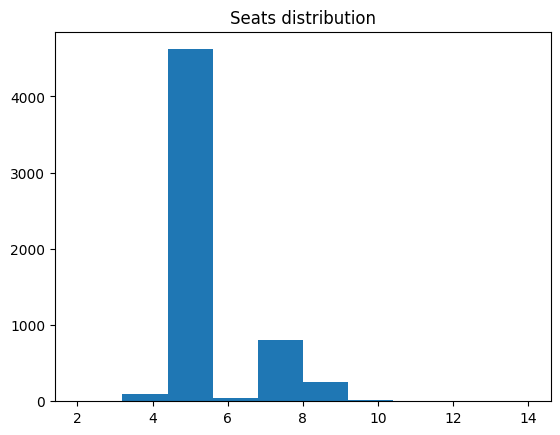

In [29]:
%matplotlib inline

plt.hist(df_train['seats'], bins = 10)
plt.title('Seats distribution')
plt.show()

Seats принимает некое конечное количество целых значений, как категориальный признак.  
 И вообще про нее можно думать, как про тип автомобиля (мотоцикл, легковой, минибус).

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [30]:
df_train.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.394733  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.919005   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    17.000000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.300000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.070000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.906371   177.000101     5.426712     3025.921087  
std      31.640418   129.440145     0.982344      945.958084  
min       0.000000    48.000000     2.000000        2.200000  
25%      68.000000   112.000000     5.000000     2250.000000  
50%      81.860000   163.000000     5.000000     3000.000000  
75%      99.000000   204.000000     5.000000     4000.000000  
max     400.000000  5100.000000    14.000000    21800.000000

Оснований скорее нет: мы заполняли меньше 3% значений для каждой колонки в не сильно skewнутых распределениях.  
А вообще могло, например, при большом количестве пропусков.  
Пусть у нас есть сто объектов с признаком который в двух случаях равен 0, а в одном - 1. Заполнив пропуски медианой мы получим 99 объектов с нулем и один с единицей.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seaborn`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

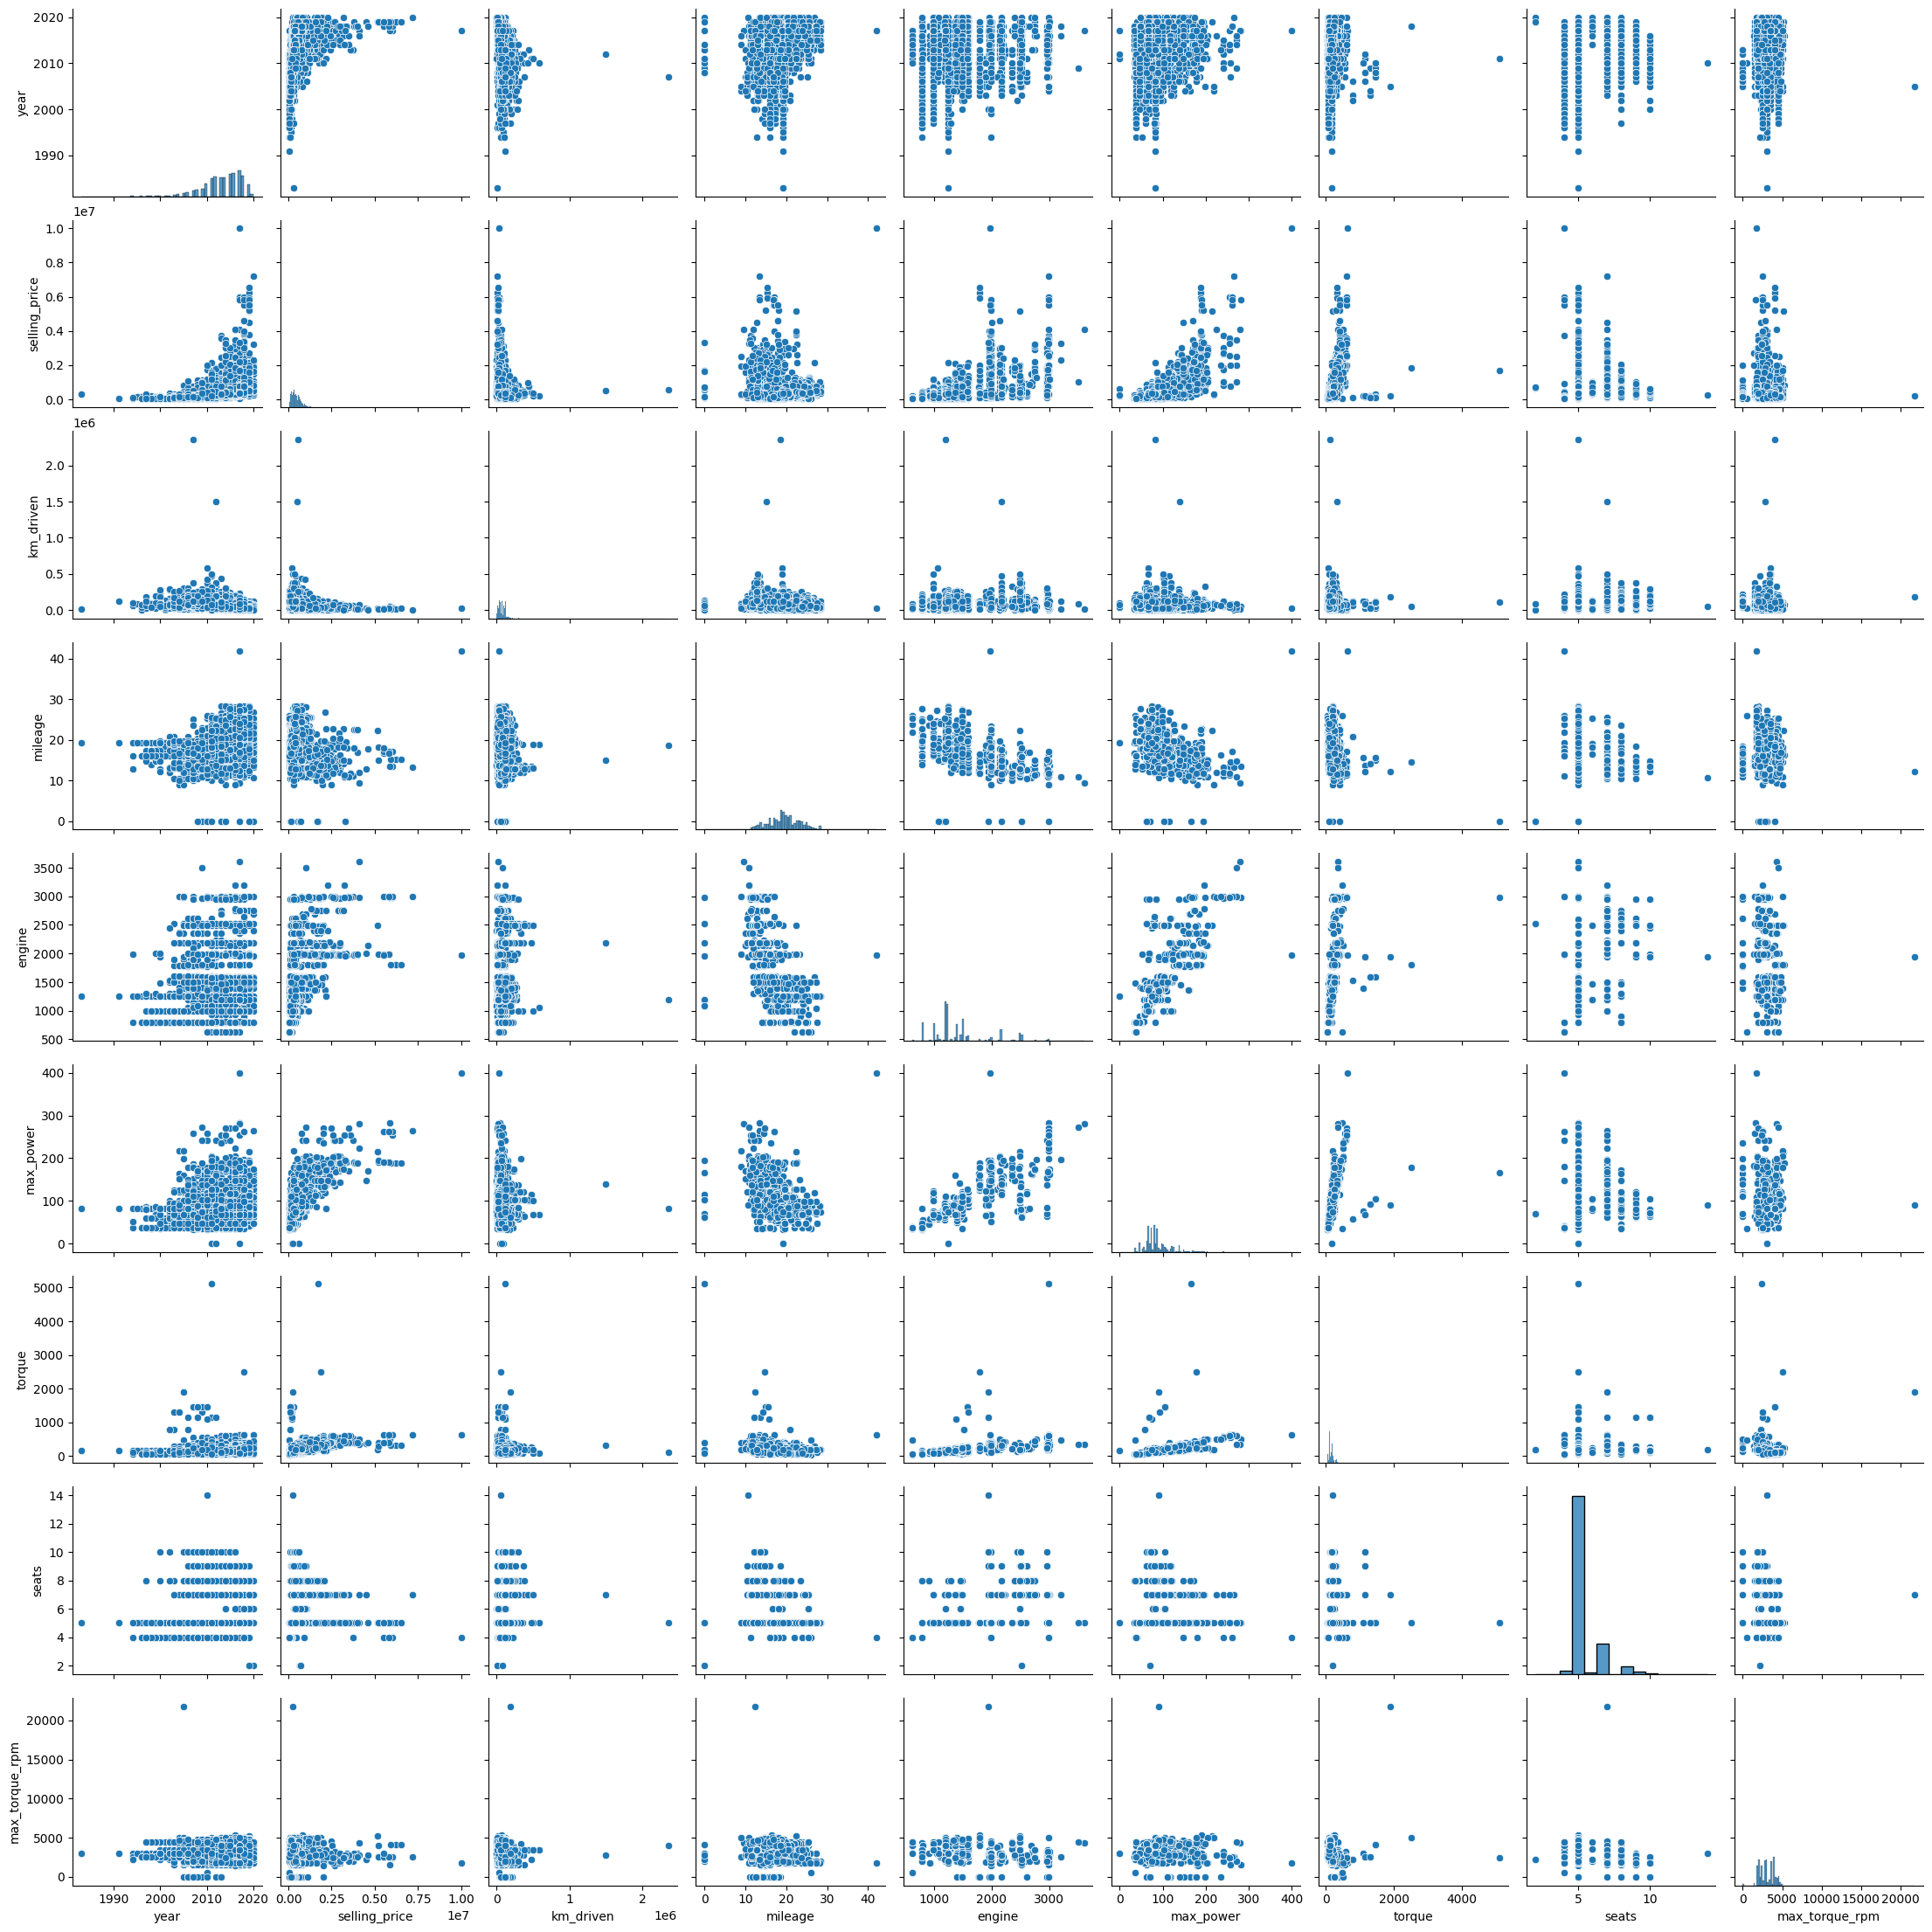

In [31]:
%matplotlib inline

sns.pairplot(df_train)

У selling_price явно есть корреляции с max_power, year и engine. Ну и можно предпложить о зависимостях этих признаков.  


P.S. Я знаю в чем разница корреляции и связи, но тут все есть один адекватный датасет и по графикам скорее видны корреляции.

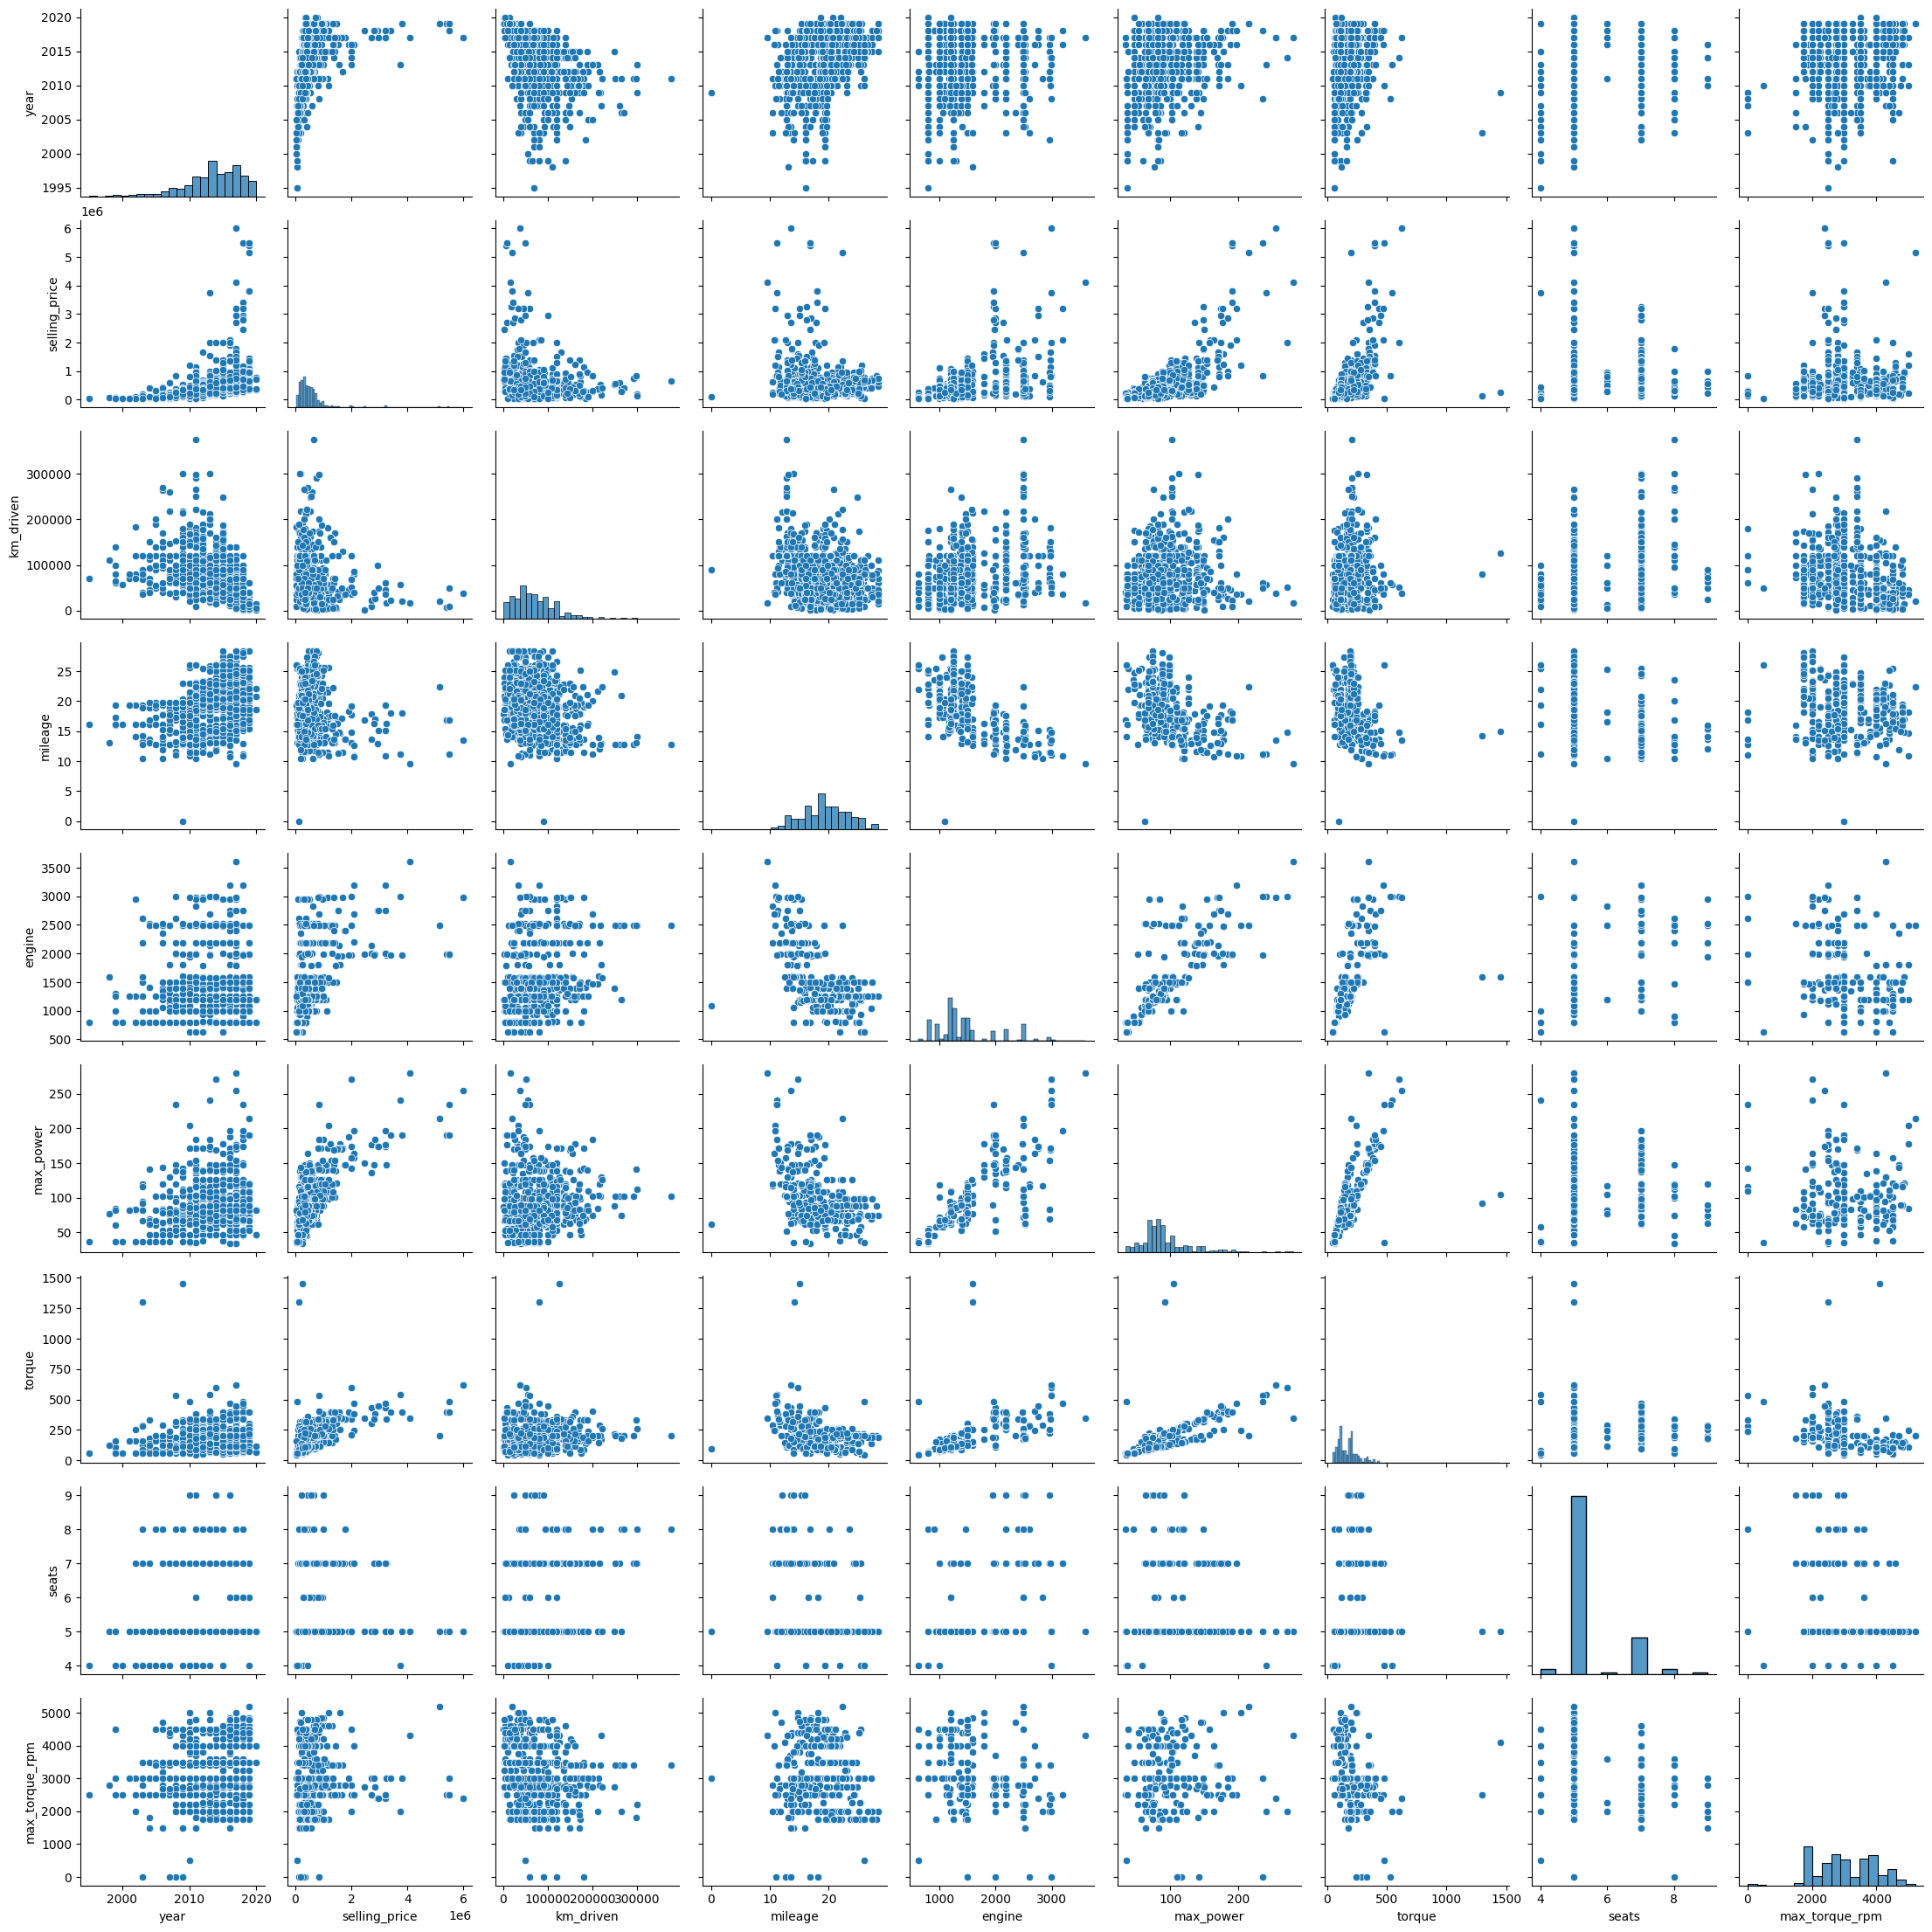

In [32]:
sns.pairplot(df_test)

Сильно не вглядываюсь, но помимо пары выбросов в трейне, графики выглядят идентичными.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [33]:
df_train.corr(numeric_only=True)

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.427279  -0.368966  0.339232  0.002819   
selling_price   0.427279       1.000000  -0.164828 -0.103673  0.447672   
km_driven      -0.368966      -0.164828   1.000000 -0.181574  0.229766   
mileage         0.339232      -0.103673  -0.181574  1.000000 -0.573593   
engine          0.002819       0.447672   0.229766 -0.573593  1.000000   
max_power       0.156858       0.692814   0.024588 -0.369620  0.681117   
torque          0.039296       0.405032   0.097187 -0.227592  0.518672   
seats           0.041178       0.149953   0.192328 -0.452696  0.652172   
max_torque_rpm  0.076274      -0.078187  -0.209218 -0.159928 -0.252805   

                max_power    torque     seats  max_torque_rpm  
year             0.156858  0.039296  0.041178        0.076274  
selling_price    0.692814  0.405032  0.149953       -0.078187  
km_driven        0.024588  0.097187  0.192328       -0.209218  
mileage         -0.369620 -0.227592 -0.452696       -0.159928  
engine           0.681117  0.518672  0.652172       -0.252805  
max_power        1.000000  0.568879  0.244112       -0.043828  
torque           0.568879  1.000000  0.257694       -0.225100  
seats            0.244112  0.257694  1.000000       -0.201491  
max_torque_rpm  -0.043828 -0.225100 -0.201491        1.000000

<Axes: >

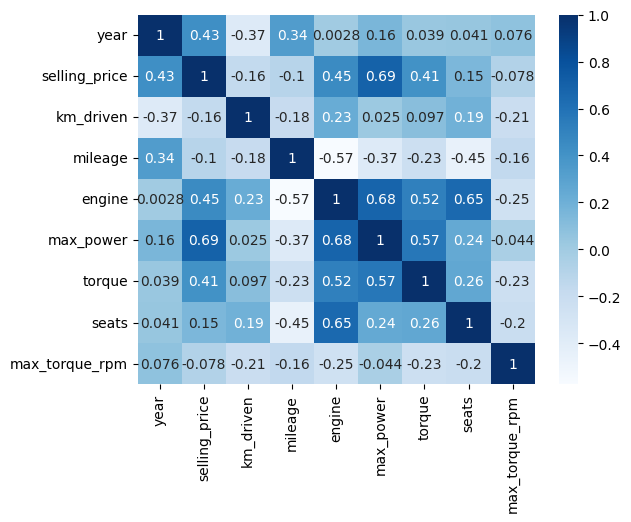

In [34]:
corr = df_train.corr(numeric_only=True)

sns.heatmap(corr, cmap="Blues", annot=True)

In [35]:
train_corr = df_train.corr(numeric_only=True)
np.abs(train_corr).min()

year              0.002819
selling_price     0.078187
km_driven         0.024588
mileage           0.103673
engine            0.002819
max_power         0.024588
torque            0.039296
seats             0.041178
max_torque_rpm    0.043828
dtype: float64

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

- 2 признака с намиеньшей корреляцией - engine и year.
- max_power и selling_price, engine и max_power.
- Нет, корреляция в данных положительная.

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`).
- [ ] Сравните результаты вычисления с библиотечной реализацией

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [36]:
#def get_rank(data):    Attempt to leave same ranks for same elements, but obviously doesn't work
#    uniq_data = np.unique(data)
#    sort_idxs = np.argsort(uniq_data)
#
#    rank = [0] * len(data)
#    for i, elem in enumerate(uniq_data):
#        idxs = np.where(data == elem)[0]
#
#        for idx in idxs:
#            rank[idx] = sort_idxs[i]
#    
#    return np.array(rank)


def get_rank(data):
    idxs = np.argsort(data, kind='stable')
    rank = [0] * len(data)

    for i, idx in enumerate(idxs):
        rank[idx] = i

    return np.array(rank)
    

def custom_spearman_corr(first, second):
    assert len(first) == len(second)
    n = len(first)

    diff_rank = get_rank(first) - get_rank(second)
    d_squared = np.square(diff_rank)

    return 1 - 6 * np.sum(d_squared)/(n**3 - n)


def df_spearman_corr(df):
    df_numeric = df.select_dtypes(include='number')

    result_data = {}

    for first_column in df_numeric.columns:
        result_data[first_column] = []
        for second_column in df_numeric.columns:
            result_data[first_column].append(custom_spearman_corr(df_numeric[first_column], df_numeric[second_column]))

    result_df = pd.DataFrame(data=result_data)
    result_df.index = df_numeric.columns

    return result_df

In [37]:
get_rank([10, 10, 2, 2, 1, 0])

array([4, 5, 2, 3, 1, 0])

In [38]:
df_spearman_corr(df_train)

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.705194  -0.563799  0.344761 -0.033671   
selling_price   0.705194       1.000000  -0.294631  0.027576  0.463759   
km_driven      -0.563799      -0.294631   1.000000 -0.194166  0.304407   
mileage         0.344761       0.027576  -0.194166  1.000000 -0.421919   
engine         -0.033671       0.463759   0.304407 -0.421919  1.000000   
max_power       0.166622       0.612627   0.041239 -0.300911  0.711746   
torque          0.100121       0.578892   0.244873 -0.153869  0.841286   
seats           0.074884       0.227972   0.182851 -0.289063  0.423272   
max_torque_rpm  0.094574      -0.119554  -0.323789 -0.166104 -0.372349   

                max_power    torque     seats  max_torque_rpm  
year             0.166622  0.100121  0.074884        0.094574  
selling_price    0.612627  0.578892  0.227972       -0.119554  
km_driven        0.041239  0.244873  0.182851       -0.323789  
mileage         -0.300911 -0.153869 -0.289063       -0.166104  
engine           0.711746  0.841286  0.423272       -0.372349  
max_power        1.000000  0.779933  0.230013       -0.035852  
torque           0.779933  1.000000  0.343475       -0.528415  
seats            0.230013  0.343475  1.000000       -0.115500  
max_torque_rpm  -0.035852 -0.528415 -0.115500        1.000000

In [39]:
df_train.corr(numeric_only=True, method='spearman')

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.707123  -0.569659  0.342029 -0.038056   
selling_price   0.707123       1.000000  -0.295665  0.027223  0.463577   
km_driven      -0.569659      -0.295665   1.000000 -0.195321  0.304504   
mileage         0.342029       0.027223  -0.195321  1.000000 -0.424663   
engine         -0.038056       0.463577   0.304504 -0.424663  1.000000   
max_power       0.165798       0.612258   0.040919 -0.301450  0.713113   
torque          0.097028       0.578464   0.244851 -0.155086  0.841953   
seats           0.048291       0.317605   0.195317 -0.434921  0.527716   
max_torque_rpm  0.090742      -0.120754  -0.327284 -0.168989 -0.379615   

                max_power    torque     seats  max_torque_rpm  
year             0.165798  0.097028  0.048291        0.090742  
selling_price    0.612258  0.578464  0.317605       -0.120754  
km_driven        0.040919  0.244851  0.195317       -0.327284  
mileage         -0.301450 -0.155086 -0.434921       -0.168989  
engine           0.713113  0.841953  0.527716       -0.379615  
max_power        1.000000  0.780021  0.304857       -0.037512  
torque           0.780021  1.000000  0.437043       -0.532795  
seats            0.304857  0.437043  1.000000       -0.200651  
max_torque_rpm  -0.037512 -0.532795 -0.200651        1.000000

Везде значения немного отличаются - в осноном на +- 1 процент, но в каких-то рядах сильно больше (например seats).  
Не до конца понимаю почему: скорее всего из-за разных вариантов обработки выдачи рангов для дубликатов.

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


/Users/22028091/Library/Python/3.9/lib/python/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


<Axes: >

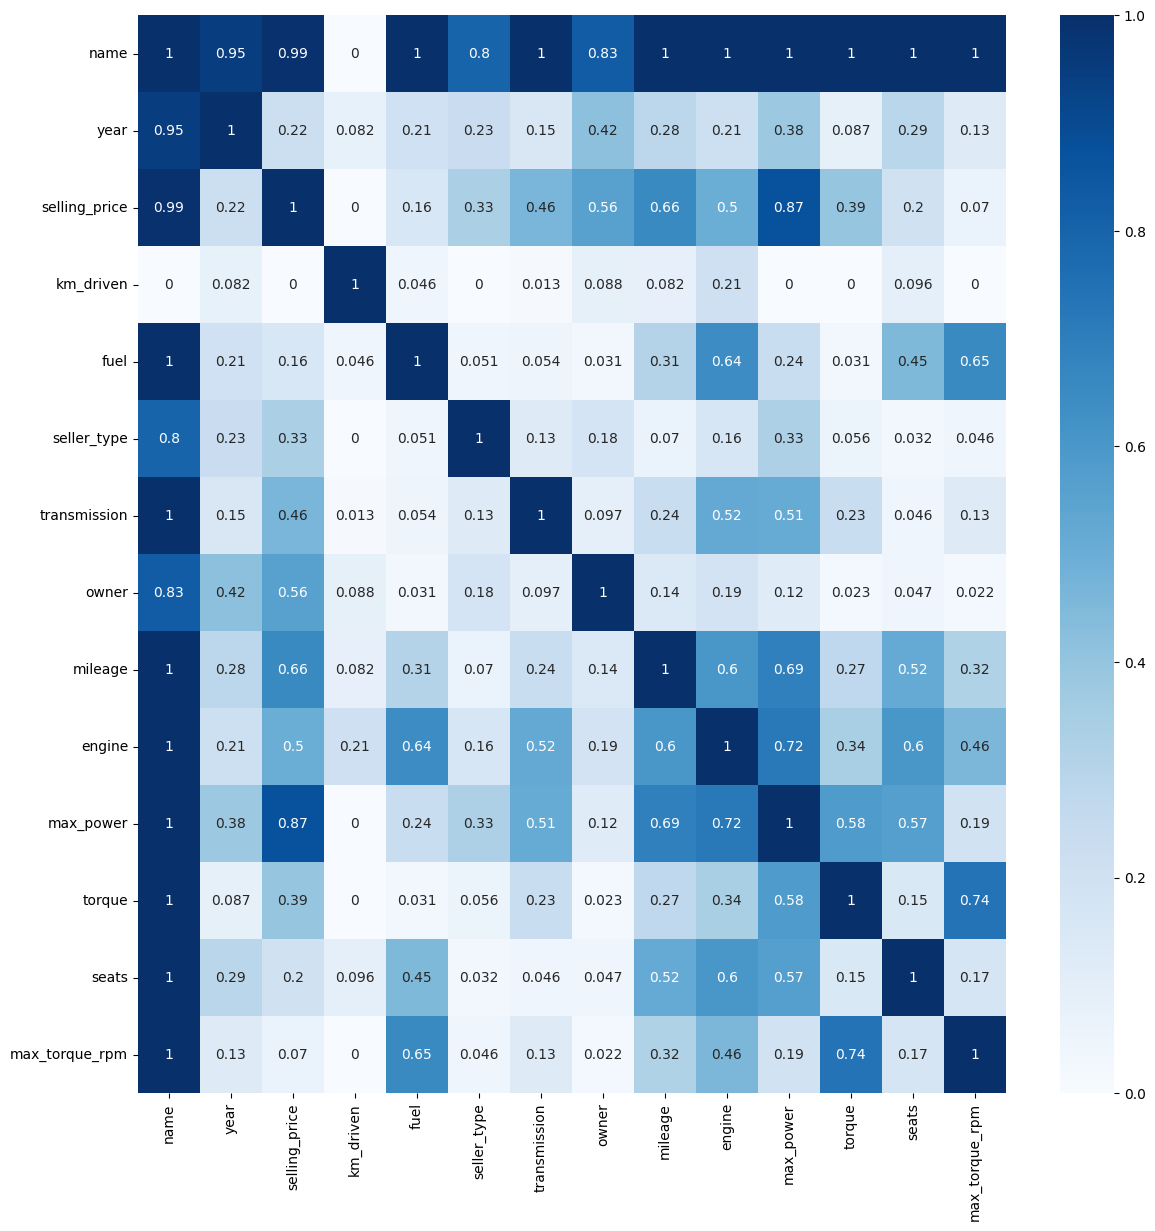

In [40]:
import phik

plt.figure(figsize=(14,14))

ph = df_train.phik_matrix()

sns.heatmap(ph, cmap="Blues", annot=True)

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

Показываю трюк: 

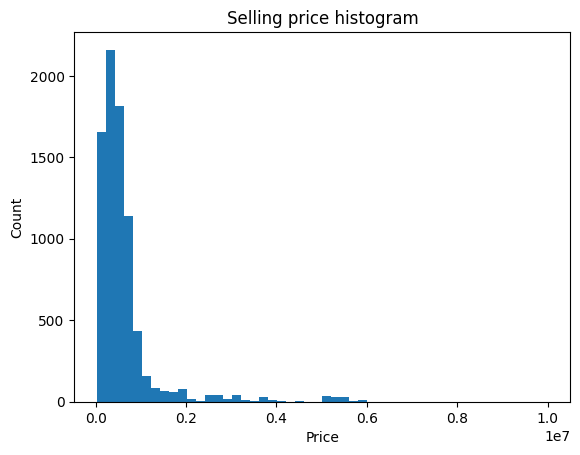

In [41]:
plt.hist(df['selling_price'], bins=50)
plt.title('Selling price histogram')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

Логарaфмическое распределение превращается, превращается в...

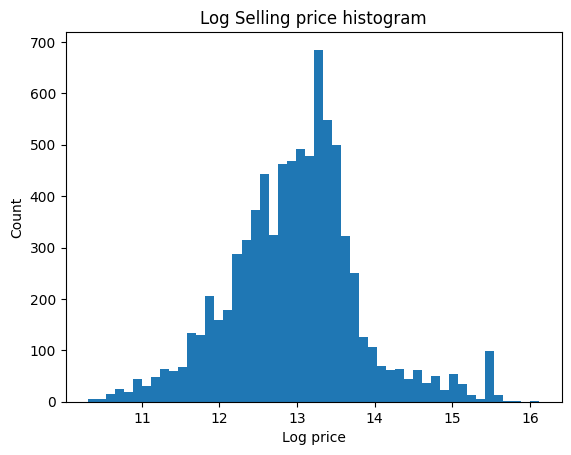

In [42]:
plt.hist(np.log(df['selling_price']), bins=50)
plt.title('Log Selling price histogram')
plt.xlabel('Log price')
plt.ylabel('Count')
plt.show()

# В НОРМАЛЬНОЕ. ВАУ.  

В общем, в какой-то момент точно стоит попробовать прологарифмироровать таргет.

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [43]:
df_train.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine              int64
max_power         float64
torque            float64
seats               int64
max_torque_rpm    float64
dtype: object

In [44]:
y_train = df_train.select_dtypes(include='number')['selling_price']
X_train = df_train.select_dtypes(include='number').drop(columns=['selling_price'])

ALARM ЗДЕСЬ БЫЛО 6 столбцов в ASSERT.

In [45]:
y_test = df_test.select_dtypes(include='number')['selling_price']
X_test = df_test.select_dtypes(include='number').drop(columns=['selling_price'])

In [46]:
assert X_test.shape == (1000, 8)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [48]:
print('R2 score:', r2_score(y_true=y_test, y_pred=preds))
print('MSE score:', MSE(y_true=y_test, y_pred=preds))

R2 score: 0.5972093337441673
MSE score: 231535576908.487


Здесь и дальше будут появляться функции для удобного сравнения в конце.

In [49]:
def only_numeric_model():
    y_train = df_train.select_dtypes(include='number')['selling_price']
    X_train = df_train.select_dtypes(include='number').drop(columns=['selling_price'])
    y_test = df_test.select_dtypes(include='number')['selling_price']
    X_test = df_test.select_dtypes(include='number').drop(columns=['selling_price'])

    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return preds, r2_score(y_true=y_test, y_pred=preds), MSE(y_true=y_test, y_pred=preds)

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

$$R^{2} = 1 - \dfrac{\sum_{i}^{n}(y_{i} - pred_{i})^2}{\sum_{i}^{n}(y_{i} - \bar{y})^2}$$

$\bar{y}$ - среднее по всем таргетам, $pred_{i}$ - i-ое предсказание, $y_i$ - i-ый таргет.

Метрика принимает значения от 1 и до минус бесконечности. Если всегда предсказывать среднее по всем таргетам, то $R_{2} = 0$.

In [50]:
def custom_r2_score(targets, preds):
    mean_target = np.mean(targets)
    numerator = np.sum((targets - preds)**2)
    denominator = np.sum((targets - mean_target)**2)

    return 1 - numerator/denominator

In [51]:
for _ in range(100):
    random_preds = np.random.random(size=len(y_test)) * 100000

    assert custom_r2_score(y_test, random_preds) == r2_score(y_test, random_preds)

`Your answer here`

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [52]:
def adjusted_r2_score(targets, preds, p):
    r2 = custom_r2_score(targets, preds)
    n = len(targets)

    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

Когда мы сравниваем модели на разных датасетах или модели с разными количествами параметров.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [54]:
scaled_model = LinearRegression()
scaled_model.fit(X_train_scaled, y_train)
preds = scaled_model.predict(X_test_scaled)

In [55]:
print('R2 score:', r2_score(y_true=y_test, y_pred=preds))
print('MSE score:', MSE(y_true=y_test, y_pred=preds))

R2 score: 0.5972093337441802
MSE score: 231535576908.4796


In [56]:
scaled_model.coef_

array([164732.85471581, -47741.02927847,   -609.44338873,  30432.86981339,
       323331.12911838,  12280.1722856 , -28737.91403207, -45672.45563186])

In [57]:
X_train.columns

Index(['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'max_torque_rpm'],
      dtype='object')

Самым важным оказался max_power

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [58]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

lasso_model.fit(X_train_scaled, y_train)
preds = lasso_model.predict(X_test_scaled)

In [59]:
print('R2 score:', r2_score(y_true=y_test, y_pred=preds))
print('MSE score:', MSE(y_true=y_test, y_pred=preds))

R2 score: 0.5972080959996359
MSE score: 231536288399.38824


In [60]:
def numerical_lasso_with_normalization_model():
    y_train = df_train.select_dtypes(include='number')['selling_price']
    X_train = df_train.select_dtypes(include='number').drop(columns=['selling_price'])
    y_test = df_test.select_dtypes(include='number')['selling_price']
    X_test = df_test.select_dtypes(include='number').drop(columns=['selling_price'])

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso()
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    return preds, r2_score(y_true=y_test, y_pred=preds), MSE(y_true=y_test, y_pred=preds)

In [61]:
lasso_model.coef_

array([164730.63934326, -47740.09396355,   -606.2672347 ,  30430.76732363,
       323332.4775723 ,  12279.66131921, -28733.97747974, -45670.37727381])

Нет, веса не занулились.

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [62]:
from sklearn.model_selection import GridSearchCV

model = Lasso()

parameter_grid = {'alpha':[0.00001, 0.001, 0.1, 0.2, 1.0, 10.0], 'max_iter':[100, 200, 500, 1000, 2000]}

cv_model = GridSearchCV(model, parameter_grid, cv=10)

cv_model.fit(X_train_scaled, y_train)

cv_preds = cv_model.predict(X_test_scaled)


print('R2 score:', r2_score(y_true=y_test, y_pred=cv_preds))
print('MSE score:', MSE(y_true=y_test, y_pred=cv_preds))

R2 score: 0.5971969234643961
MSE score: 231542710691.6829


In [63]:
def numerical_lasso_with_normalization_and_cv():
    y_train = df_train.select_dtypes(include='number')['selling_price']
    X_train = df_train.select_dtypes(include='number').drop(columns=['selling_price'])
    y_test = df_test.select_dtypes(include='number')['selling_price']
    X_test = df_test.select_dtypes(include='number').drop(columns=['selling_price'])

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso()
    parameter_grid = {'alpha':[0.00001, 0.001, 0.1, 0.2, 1.0, 10.0], 'max_iter':[100, 200, 500, 1000, 2000]}
    cv_model = GridSearchCV(model, parameter_grid, cv=10)
    cv_model.fit(X_train_scaled, y_train)
    preds = cv_model.predict(X_test_scaled)

    return preds, r2_score(y_true=y_test, y_pred=preds), MSE(y_true=y_test, y_pred=preds)

In [64]:
cv_model.best_params_

{'alpha': 10.0, 'max_iter': 100}

In [65]:
cv_model.best_estimator_.coef_

array([164710.21877832, -47731.76439564,   -576.96083608,  30412.19173679,
       323344.67543754,  12275.06784289, -28698.34282361, -45651.40542308])

* Gridsearch перебирает по факту декартово произведение множества всех параметров. В этом случае мощность этого множества - 6 * 5 = 30.
* alpha - коэффициент регуляризации, max_iter - количество итераций.
* {'alpha': 10.0, 'max_iter': 100}, Веса не занулились.

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [66]:
%%capture output

from sklearn.linear_model import ElasticNet

model = ElasticNet()

parameter_grid = {'alpha':[0.001, 0.1, 0.2, 1.0, 10.0, 200.0], 'max_iter':[500, 1000, 2000, 3000, 5000], 'l1_ratio': [0.0001, 0.001, 0.1, 0.2, 0.5, 0.8, 0.9, 0.999, 0.9999]}

cv_model = GridSearchCV(model, parameter_grid, cv=10)

cv_model.fit(X_train, y_train)

cv_preds = cv_model.predict(X_test)


In [67]:
def numerical_elastic_net_with_normalization_and_cv():
    y_train = df_train.select_dtypes(include='number')['selling_price']
    X_train = df_train.select_dtypes(include='number').drop(columns=['selling_price'])
    y_test = df_test.select_dtypes(include='number')['selling_price']
    X_test = df_test.select_dtypes(include='number').drop(columns=['selling_price'])

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso()
    parameter_grid = {'alpha':[0.00001, 0.001, 0.1, 0.2, 1.0, 10.0], 'max_iter':[100, 200, 500, 1000, 2000]}
    cv_model = GridSearchCV(model, parameter_grid, cv=10)
    cv_model.fit(X_train_scaled, y_train)
    preds = cv_model.predict(X_test_scaled)

    return preds, r2_score(y_true=y_test, y_pred=preds), MSE(y_true=y_test, y_pred=preds)

In [68]:
print('R2 score:', r2_score(y_true=y_test, y_pred=cv_preds))
print('MSE score:', MSE(y_true=y_test, y_pred=cv_preds))

R2 score: 0.5972093326014962
MSE score: 231535577565.32693


In [69]:
cv_model.best_params_

{'alpha': 0.001, 'l1_ratio': 0.9999, 'max_iter': 500}

In [70]:
cv_model.best_estimator_.coef_

array([ 4.02251376e+04, -7.94809638e-01, -1.55522049e+02,  6.26679001e+01,
        1.02198023e+04,  9.48795571e+01, -2.92569273e+04, -4.82858236e+01])

* 6 * 5 * 9 = 270 моделей
* {'alpha': 0.001, 'l1_ratio': 0.9999, 'max_iter': 500}

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



Ну все пошел считать градиент L0 регуляризации и делать градиентный спуск.  
Секундочку...  
Нет

L0 регуряризацию можно устроить перебрав все множества колонок, которые у нас есть. Благо их немного.   
Ну а коэффициент регуляризации это просто конфетка которую мы даем модели за использование меньшего числа признаков.  
powerset стырен со stackoverflow: https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

In [71]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def numerical_Linear_with_L0():
    y_train = df_train.select_dtypes(include='number')['selling_price']
    X_train = df_train.select_dtypes(include='number').drop(columns=['selling_price'])
    y_test = df_test.select_dtypes(include='number')['selling_price']
    X_test = df_test.select_dtypes(include='number').drop(columns=['selling_price'])


    parameter_grid = {'alpha':[1, 10, 1000, 100000, 10000000, 10000000000, 1e15, 1e20]}
    for alpha in parameter_grid['alpha']:
        best_score = np.inf
        best_columns = []

        for columns in list(powerset(X_train.columns)):
            if len(columns) == 0:
                continue

            columns = list(columns)
            X_train_col = X_train[columns]
            X_test_col = X_test[columns]

            scaler = StandardScaler()
            scaler.fit(X_train_col)
            X_train_scaled = scaler.transform(X_train_col)
            X_test_scaled = scaler.transform(X_test_col)

            model = LinearRegression()
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_test_scaled)

            score = MSE(y_true=y_test, y_pred=preds) + alpha * len(columns)

            if score < best_score:
                best_score = score
                best_columns = columns
        
        print(f"For alpha = {alpha}: Best MSE + L0 = {best_score} for columns {best_columns}")

    return None

In [72]:
numerical_Linear_with_L0()

For alpha = 1: Best MSE + L0 = 231368266558.1595 for columns ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'max_torque_rpm']
For alpha = 10: Best MSE + L0 = 231368266621.1595 for columns ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'max_torque_rpm']
For alpha = 1000: Best MSE + L0 = 231368273551.1595 for columns ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'max_torque_rpm']
For alpha = 100000: Best MSE + L0 = 231368966551.1595 for columns ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'max_torque_rpm']
For alpha = 10000000: Best MSE + L0 = 231428664027.39447 for columns ['year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm']
For alpha = 10000000000: Best MSE + L0 = 260671222328.29556 for columns ['year', 'max_power']
For alpha = 1000000000000000.0: Best MSE + L0 = 1000280076360634.8 for columns ['max_power']
For alpha = 1e+20: Best MSE + L0 = 1.0000000028007635e+20 for columns ['max_power']


Ну, в общем по одному отбрасываются самые не информативные колонки.  
Чем больше коэффициент, тем больше инцентивы оставлять меньше признаков. Пока не остается один: max_power.

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [73]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner  mileage  engine  max_power  torque  \
0  Individual       Manual   First Owner    23.40    1248      74.00  190.00   
1  Individual       Manual  Second Owner    21.14    1498     103.52  250.00   
2  Individual       Manual   First Owner    23.00    1396      90.00  224.00   
3  Individual       Manual   First Owner    16.10    1298      88.20  115.00   
4  Individual       Manual   First Owner    20.14    1197      81.86  113.75   

   seats  max_torque_rpm  
0      5          2000.0  
1      5          2500.0  
2      5          2750.0  
3      5          4500.0  
4      5          4000.0

In [74]:
df_train['name'] = df_train['name'].apply(lambda x: x.split(' ')[0])
df_test['name'] = df_test['name'].apply(lambda x: x.split(' ')[0])

In [75]:
X_train_cat = df_train

In [76]:
X_train_cat.describe(include='object')

name    fuel seller_type transmission        owner
count     5840    5840        5840         5840         5840
unique      30       4           3            2            5
top     Maruti  Diesel  Individual       Manual  First Owner
freq      1804    3177        5223         5336         3603

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориальные фичи и ``seats`` методом OneHot-кодирования.

In [77]:
X_train_cat = df_train[['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']]
X_test_cat = df_test[['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']]

In [78]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas

ohe_enc = OneHotEncoder(handle_unknown='ignore', drop='first')

ohe_enc.fit(X_train_cat)

X_train_cat = ohe_enc.transform(X_train_cat)
X_test_cat = ohe_enc.transform(X_test_cat)

/Users/22028091/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [79]:
non_encoded_columns = list(set(df_train.columns) - set(['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats', 'selling_price']))
non_encoded_df_train = df_train[non_encoded_columns]
non_encoded_df_test = df_test[non_encoded_columns]

In [80]:
X_train = np.concatenate([X_train_cat.toarray(), non_encoded_df_train.values], axis=1)
X_test = np.concatenate([X_test_cat.toarray(), non_encoded_df_test.values], axis=1)

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

* Очень общий вопрос.
* Преобразование должно быть обратимым. Но поскольку по природе преобразования, ровно в одной колонке из n стоит 1, то любую колонку можно восстановить из оставшихся n - 1.
* Нет, преобразование перестанет быть обратимым.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [81]:
%%capture output
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

model = Ridge()

parameter_grid = {'alpha':[0.00001, 0.001, 0.1, 0.2, 1.0, 10.0],}

cv_model = GridSearchCV(model, parameter_grid, cv=10, scoring='r2')

cv_model.fit(X_train, y_train)

cv_preds = cv_model.predict(X_test)

In [82]:
print('R2 score:', r2_score(y_true=y_test, y_pred=cv_preds))
print('MSE score:', MSE(y_true=y_test, y_pred=cv_preds))

R2 score: 0.7810836004751758
MSE score: 125839397744.42334


Да, как это видно из метрик, сильно удалось поднять качество.

In [83]:
def ridge_with_cat_features():
    X_train_cat = df_train[['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']]
    X_test_cat = df_test[['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']]

    ohe_enc = OneHotEncoder(handle_unknown='ignore', drop='first')

    ohe_enc.fit(X_train_cat)

    X_train_cat = ohe_enc.transform(X_train_cat)
    X_test_cat = ohe_enc.transform(X_test_cat)

    non_encoded_columns = list(set(df_train.columns) - set(['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats', 'selling_price']))
    non_encoded_df_train = df_train[non_encoded_columns]
    non_encoded_df_test = df_test[non_encoded_columns]

    X_train = np.concatenate([X_train_cat.toarray(), non_encoded_df_train.values], axis=1)
    X_test = np.concatenate([X_test_cat.toarray(), non_encoded_df_test.values], axis=1)

    model = Ridge()

    parameter_grid = {'alpha':[0.00001, 0.001, 0.1, 0.2, 1.0, 10.0],}

    cv_model = GridSearchCV(model, parameter_grid, cv=10, scoring='r2')

    cv_model.fit(X_train, y_train)

    preds = cv_model.predict(X_test)

    return preds, r2_score(y_true=y_test, y_pred=preds), MSE(y_true=y_test, y_pred=preds)

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*  
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);  
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)  
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)  

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;  
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много  
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить  
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать  

И так далее...

Feel Free to Try!

Идея номер один - прологарифмировать selling_price. Это можно придумать из графиков.  
Идея номер 2 - сделать полиномиальные признаки - над этим можно даже не думать. Ну кроме лютого увеличения параметров, после которого нужно следить за переобучеием, поэтому не будем этого делать на всех фичах. А вот только на численных - можно.  
Вперед:

In [84]:
from sklearn.preprocessing import PolynomialFeatures

def ridge_with_cat_and_poly_num_features():
    X_train_cat = df_train[['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']]
    X_test_cat = df_test[['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']]

    ohe_enc = OneHotEncoder(handle_unknown='ignore', drop='first')

    ohe_enc.fit(X_train_cat)

    X_train_cat = ohe_enc.transform(X_train_cat)
    X_test_cat = ohe_enc.transform(X_test_cat)

    #for the last part
    with open('encoder.pickle', 'wb') as f:
        pickle.dump(ohe_enc, f)

    y_train_log = np.log(df_train['selling_price'])

    non_encoded_columns = list(set(df_train.columns) - set(['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats', 'selling_price']))
    non_encoded_df_train = df_train[non_encoded_columns]
    non_encoded_df_test = df_test[non_encoded_columns]

    poly = PolynomialFeatures(2)

    non_encoded_df_train = poly.fit_transform(non_encoded_df_train)
    non_encoded_df_test = poly.fit_transform(non_encoded_df_test)

    X_train = np.concatenate([X_train_cat.toarray(), non_encoded_df_train], axis=1)
    X_test = np.concatenate([X_test_cat.toarray(), non_encoded_df_test], axis=1)

    #for the last part
    with open('poly.pickle', 'wb') as f:
        pickle.dump(poly, f)

    model = Ridge()

    parameter_grid = {'alpha':[0.00001, 0.001, 0.1, 0.2, 1.0, 10.0],}

    cv_model = GridSearchCV(model, parameter_grid, cv=10, scoring='r2')

    cv_model.fit(X_train, y_train_log)

    with open('model.pickle', 'wb') as f:
        pickle.dump(cv_model.best_estimator_, f)

    preds = np.exp(cv_model.predict(X_test))

    return preds, r2_score(y_test, preds), MSE(y_test, preds)

In [85]:
%%capture output
preds, r2_log, mse_log = ridge_with_cat_and_poly_num_features()

In [86]:
print('R2 score:', r2_score(y_true=y_test, y_pred=preds))
print('MSE score:', MSE(y_true=y_test, y_pred=preds))

R2 score: 0.9412534518201052
MSE score: 33769193438.993164


Insane imporvements. Правда только логарифмирование таргета поднимает r2 до 91, так что это просто carry.

In [87]:
%%capture output
all_models = [only_numeric_model(), numerical_lasso_with_normalization_model(), numerical_lasso_with_normalization_and_cv(), numerical_elastic_net_with_normalization_and_cv(), ridge_with_cat_features(), ridge_with_cat_and_poly_num_features()]
all_model_names = ['Lin reg/num', 'Lasso/num + normalization', 'Lasso/num + normalization + cv', 'Elastic Net/num + normalization + cv', 'Ridge/num + cat', 'Omega Ridge model with log target and poly features']

In [88]:
for i, model in enumerate(all_models):
    model_name = all_model_names[i]

    preds, _, _ = model

    print(f"{model_name} scored {r2_score(y_test, preds)} on R2 metric")

Lin reg/num scored 0.5972093337441673 on R2 metric
Lasso/num + normalization scored 0.5972080959996359 on R2 metric
Lasso/num + normalization + cv scored 0.5971969234643961 on R2 metric
Elastic Net/num + normalization + cv scored 0.5971969234643961 on R2 metric
Ridge/num + cat scored 0.7810836004751758 on R2 metric
Omega Ridge model with log target and poly features scored 0.9412534518201052 on R2 metric


In [89]:
for i, model in enumerate(all_models):
    model_name = all_model_names[i]

    preds, _, _ = model

    print(f"{model_name} scored {MSE(y_test, preds)} on MSE")

Lin reg/num scored 231535576908.487 on MSE
Lasso/num + normalization scored 231536288399.38824 on MSE
Lasso/num + normalization + cv scored 231542710691.6829 on MSE
Elastic Net/num + normalization + cv scored 231542710691.6829 on MSE
Ridge/num + cat scored 125839397744.42334 on MSE
Omega Ridge model with log target and poly features scored 33769193438.993164 on MSE


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какая лучше всего решает задачу бизнеса

In [90]:
def business_metric(y_true, y_pred):
    good_pred_count = 0
    n = len(y_true)
    for i in range(n):
        if y_pred[i] <= 1.1 * y_true[i] and y_pred[i] >= 0.9 * y_true[i]:
            good_pred_count += 1

    return good_pred_count / n

In [91]:
for i, model in enumerate(all_models):
    model_name = all_model_names[i]

    preds, _, _ = model

    print(f"{model_name} scored {business_metric(y_test, preds)} on the business metric")

Lin reg/num scored 0.239 on the business metric
Lasso/num + normalization scored 0.239 on the business metric
Lasso/num + normalization + cv scored 0.239 on the business metric
Elastic Net/num + normalization + cv scored 0.239 on the business metric
Ridge/num + cat scored 0.31 on the business metric
Omega Ridge model with log target and poly features scored 0.39 on the business metric


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



Исскуственно увеличим штраф за ошибку недопрогноза в квадратичной фукнции. Супер бизнессовая метрика.

In [92]:
def your_business_metric(y_true, y_pred):
    under_pred_coef = 3
    metric = 0

    for i in range(len(y_true)):
        if y_true[i] < y_pred[i]:
            metric += (y_true[i] - y_pred[i])**2
        else:
            metric += under_pred_coef * (y_true[i] - y_pred[i])**2

    return metric / len(y_true)

In [93]:
for i, model in enumerate(all_models):
    model_name = all_model_names[i]

    preds, _, _ = model

    print(f"{model_name} scored {your_business_metric(y_test, preds)} on the custom business metric")

Lin reg/num scored 639963084764.292 on the custom business metric
Lasso/num + normalization scored 639965606862.0082 on the custom business metric
Lasso/num + normalization + cv scored 639988370719.9612 on the custom business metric
Elastic Net/num + normalization + cv scored 639988370719.9612 on the custom business metric
Ridge/num + cat scored 319582731789.1986 on the custom business metric
Omega Ridge model with log target and poly features scored 82971308300.83278 on the custom business metric


# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>

Это кот Елены. 

Очевидно, я не умею играть в эту игру. И даже не знаю CV, чтобы по фотке кота угадывать хозяина с помщью модельки. Или знаю?